Some relevant columns in the dataset:

* Date - The date of the observation
* AveragePrice - the average price of a single avocado
* type - conventional or organic
* year - the year
* Region - the city or region of the observation
* Total Volume - Total number of avocados sold
* 4046 - Total number of avocados with PLU 4046 sold
* 4225 - Total number of avocados with PLU 4225 sold
* 4770 - Total number of avocados with PLU 4770 sold

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA

from yellowbrick.regressor import ResidualsPlot

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [6]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [7]:
df.shape

(18249, 13)

In [8]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [9]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['date', 'averageprice', 'total_volume', '4046', '4225', '4770',
       'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'type', 'year',
       'region'],
      dtype='object')

In [10]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_week'] = pd.DatetimeIndex(df['date']).dayofweek
df['monthyear'] = pd.to_datetime(df['date']).dt.to_period('M').dt.to_timestamp()

In [11]:
df.head()

,date,averageprice,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,month,day,day_of_week,monthyear
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27,6,2015-12-01
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20,6,2015-12-01
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13,6,2015-12-01
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6,6,2015-12-01
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29,6,2015-11-01


In [12]:
df['type'].value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [13]:
df['year'].value_counts()

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

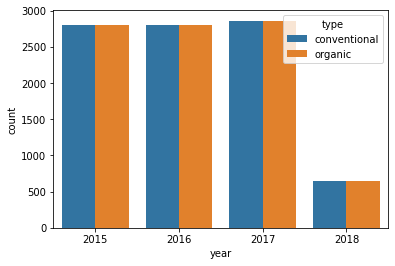

In [14]:
sns.countplot('year', data=df, hue='type');

> Observations:
- ในแต่ละปี ประเภทอะโวคาโด้มีจำนวนพอๆกัน

In [15]:
df['region'].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

> Observations:
- ในแต่ละรัฐ มีจำนวน record เท่ากัน 338 ยกเว้น WestTexNewMexico มี 335

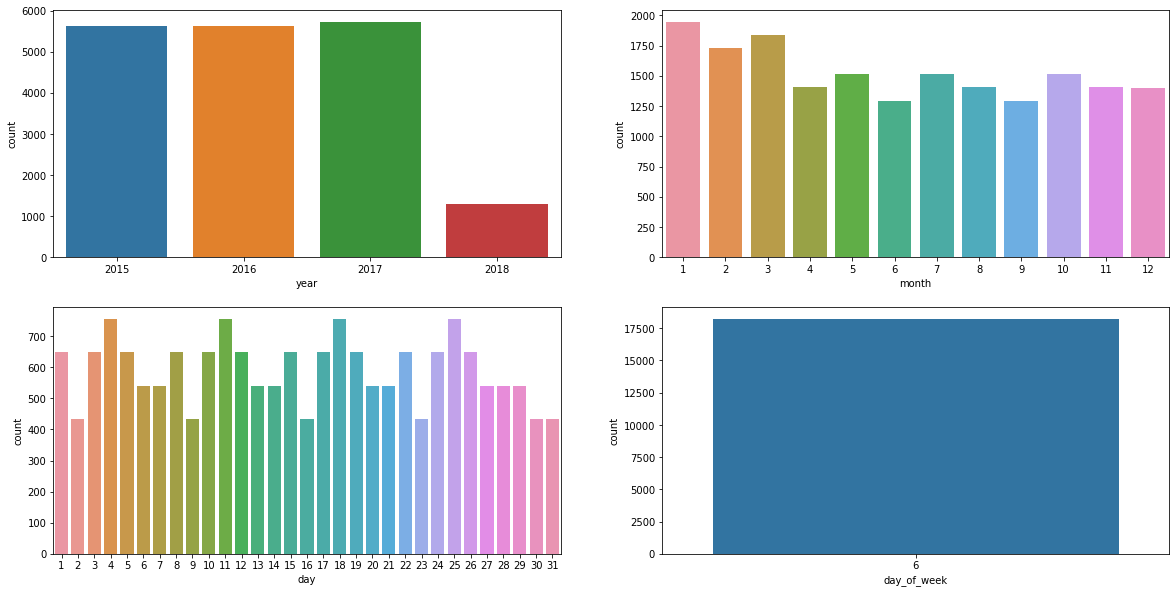

In [16]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.countplot('year', data=df, ax=ax[0,0])
sns.countplot('month', data=df, ax=ax[0,1])
sns.countplot('day', data=df, ax=ax[1,0])
sns.countplot('day_of_week', data=df, ax=ax[1,1])

plt.show()

> Observations:
- กราฟ year แต่ละปีมีจำนวนเท่าๆกัน ยกเว้น 2018!
- กราฟ month เดือน 1-3 มีจำนวนข้อมูลมากกว่าที่เหลือ
- กราฟ day_of_week = 6 อย่างเดียว แปลว่า ข้อมูลถูกบันทึกทุกๆวันอาทิตย์ ดังนั้นกราฟรายวัน day ก็ไม่มีประโยชน์

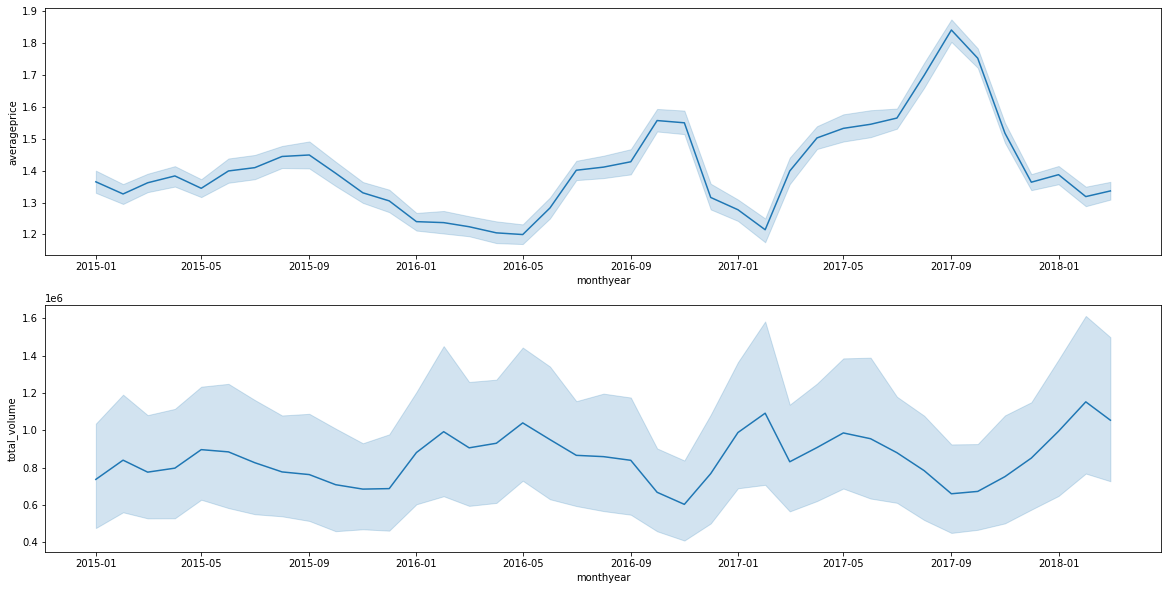

In [17]:
fig, ax = plt.subplots(2,1, figsize=(20,10))

sns.lineplot(x='monthyear', y='averageprice', data=df, ax=ax[0])
sns.lineplot(x='monthyear', y='total_volume', data=df, ax=ax[1])

plt.show()

> Observations:
- ราคาขายอะโวคาโด้สูงขึ้นผิดปกติในช่วง Sep 2017
- ช่วงต้นปีอะโวคาโด้ขายดี

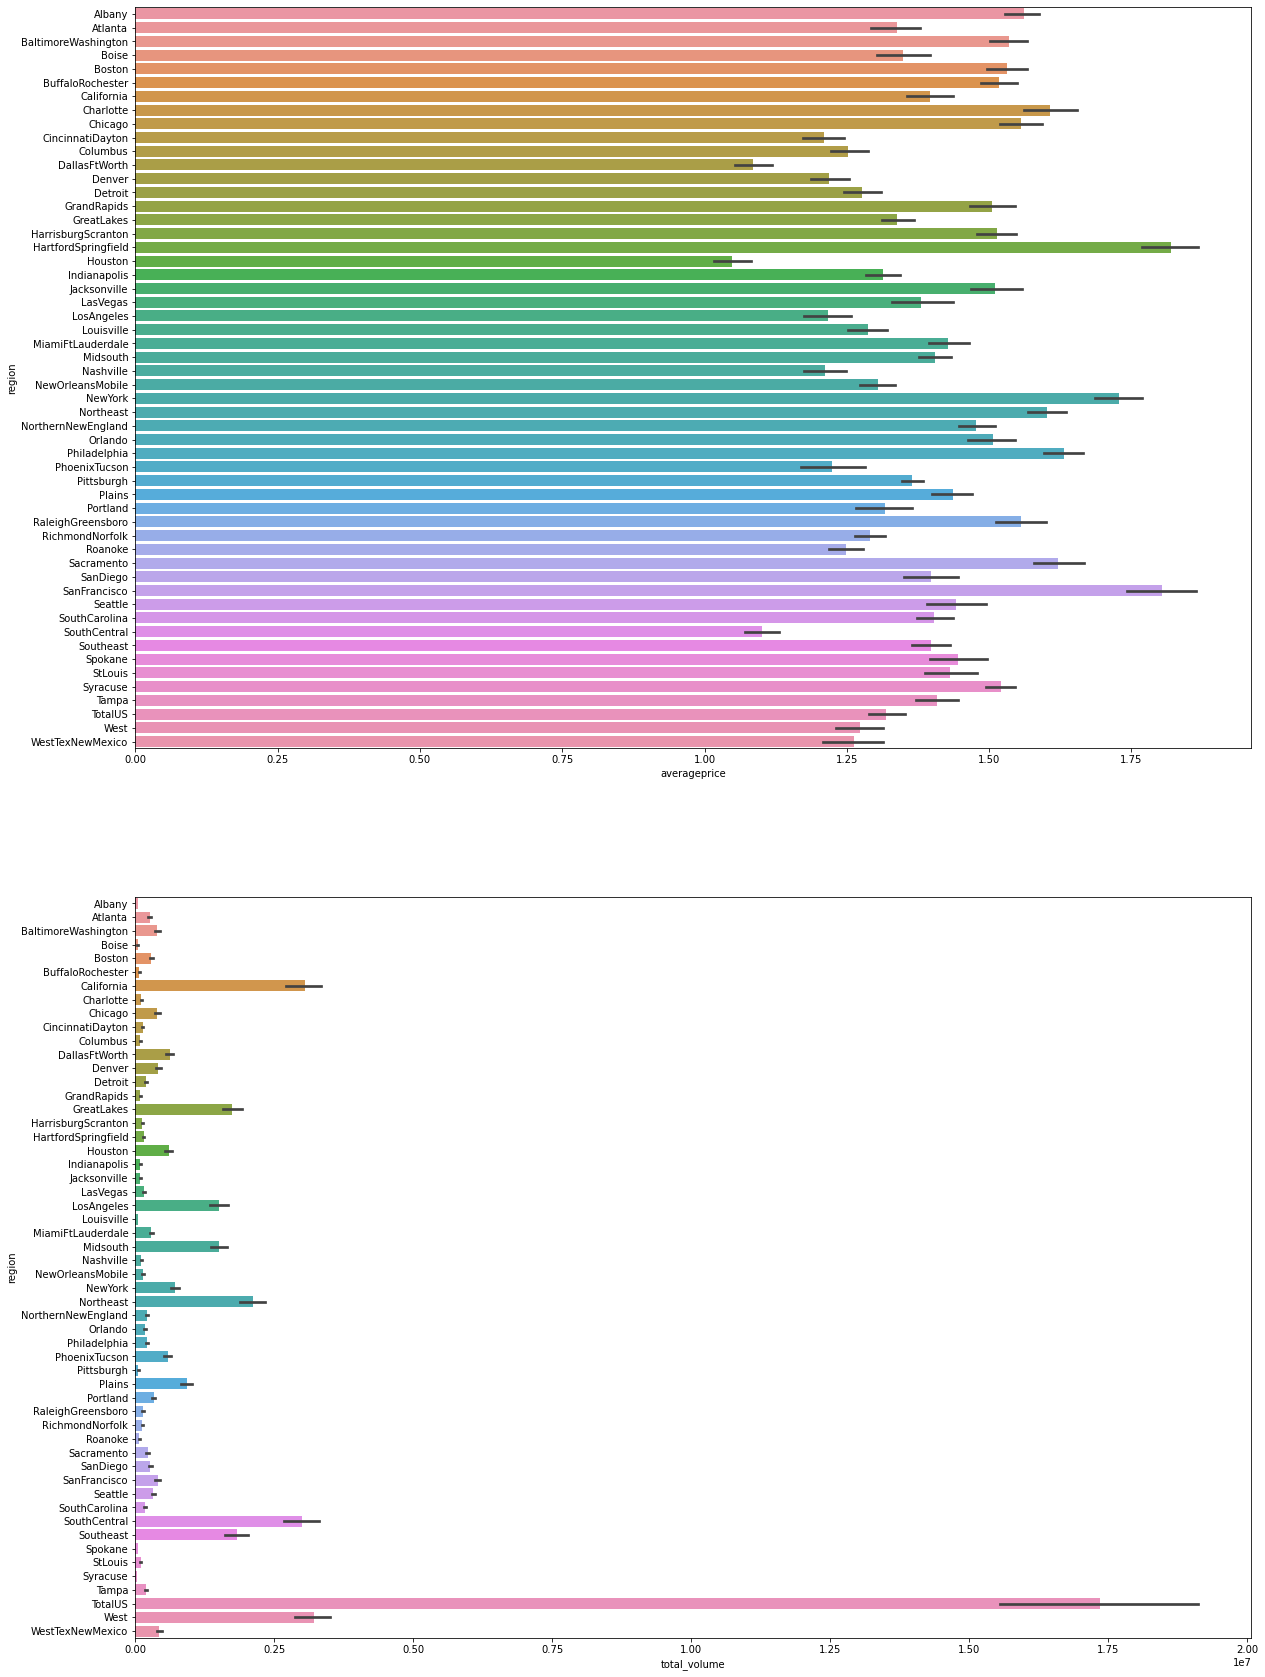

In [18]:
fig, ax = plt.subplots(2,1, figsize=(20,30))

sns.barplot(x='averageprice', y='region', data=df, ax=ax[0])
sns.barplot(x='total_volume', y='region', data=df, ax=ax[1])

plt.show()